In [1]:
# importing tools 
import s3fs
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt 
import cmocean
import math
#for removing warnings
import warnings

In [2]:
# open the data with s3fs from the databucket 
fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
data_path1 = 's3://velocity-u.zarr'
data_path2 = 's3://velocity-v.zarr'
data_path3 = 's3://data/CREG12.L75-REF08_mesh_zgr.zarr'
data_path4 = 's3://data/modmoor_varianceII.zarr'

remote_files1 = fsg.glob(data_path1)
remote_files2 = fsg.glob(data_path2)
remote_files3 = fsg.glob(data_path3)
remote_files4 = fsg.glob(data_path4)

store1 = s3fs.S3Map(root=data_path1, s3=fsg, check=False)
store2 = s3fs.S3Map(root=data_path2, s3=fsg, check=False)
store3 = s3fs.S3Map(root=data_path3, s3=fsg, check=False)
store4 = s3fs.S3Map(root=data_path4, s3=fsg, check=False)

du = xr.open_zarr(store=store1, consolidated=True)
dv = xr.open_zarr(store=store2, consolidated=True)
dzz = xr.open_zarr(store=store3, consolidated=True)
dvv = xr.open_zarr(store=store4, consolidated=True)

In [3]:
import pickle
import boto3
import os
import io

# Pickles 
credentials = open(os.path.join(os.environ['HOME'],".aws", "credentials")).read().rstrip().split("\n")
ACCESS_KEY = credentials[1].split("=")[1]
SECRET_ACCESS_KEY = credentials[2].split("=")[1]

bucket_name = 'data'
object_name = 'eof_mod_info_ice_icefree3.pickle'

s3client = boto3.client('s3'
                        ,endpoint_url = 'https://karen.uiogeo-apps.sigma2.no'
                        ,aws_access_key_id = ACCESS_KEY
                        ,aws_secret_access_key = SECRET_ACCESS_KEY
                       )

#Now to load the pickled file
response = s3client.get_object(Bucket=bucket_name, Key=object_name)

body = response['Body'].read()
data = pickle.loads(body)
#data

In [4]:
def open_s3fs(path):
    # open the data with s3fs from the databucket 
    fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
    data_path = f's3://{path}'
    remote_files = fsg.glob(data_path)
    fileset = [fsg.open(file) for file in remote_files]
    #open the dataset 
    dset = xr.open_mfdataset(fileset, 
                             #combine='by_coords',
                             compat='override')
    return dset

In [5]:
dh = open_s3fs('ice-model/CREG12.L75-REF08_y2000.5d_siconc_mean.nc')

In [6]:
u = du.vozocrtx.isel(x=slice(200,1400),y=slice(650,1800))
u = u.rename({'depthu' : 'depth'})
v = dv.vomecrty.isel(x=slice(200,1400),y=slice(650,1800))
v = v.rename({'depthv' : 'depth'})

bathym = dzz.mbathy.isel(x=slice(200,1400),y=slice(650,1800)).squeeze(axis=0)

In [8]:
u.nav_lat.max().values

array(89.95911, dtype=float32)

In [9]:
u.nav_lon.values

array([[ -81.21222 ,  -81.1375  ,  -81.06274 , ...,   29.611267,
          29.689188,   29.767054],
       [ -81.232895,  -81.15822 ,  -81.0835  , ...,   29.64355 ,
          29.72144 ,   29.799274],
       [ -81.25365 ,  -81.179016,  -81.10435 , ...,   29.675947,
          29.753805,   29.831608],
       ...,
       [-131.83008 , -131.90262 , -131.9752  , ...,  114.89426 ,
         114.81782 ,  114.74144 ],
       [-131.854   , -131.92659 , -131.99924 , ...,  114.93157 ,
         114.855095,  114.77868 ],
       [-131.87785 , -131.9505  , -132.02318 , ...,  114.968765,
         114.89225 ,  114.815796]], dtype=float32)

In [7]:
not_ice = [(912,10),(900,233),(758,110)]
ice_slope = [(870,600),(820,200),(475,525),(197,900)]
ice_not_slope = [(530,625),(530,985)]

pickl =['ice_free_stad', 'ice_free_wsc', 'ice_free_greenland', 
        'ice_slope_barents', 'ice_slope_lofoten_basin', 'ice_slope_canada',
             'ice_flat_canada_basin', 'ice_flat_bering']
moor_l = [[912,  10],
         [900, 233],
         [758,110],
         [870, 600],
         [870, 845],
         [475, 525],
         #[197, 900],#
         [530, 625],
         [530, 985]] #

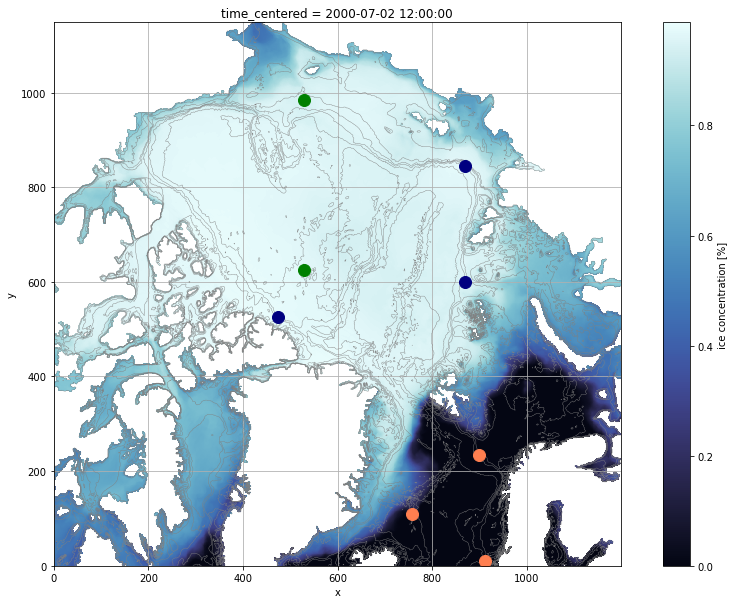

In [8]:
import cmocean
fig, ax = plt.subplots(figsize=(15,10))
ax.contour(bathym, colors='grey',levels=8, linewidths=0.4)
dh.siconc.isel(x=slice(200,1400),y=slice(650,1800)).plot(cmap=plt.get_cmap(cmocean.cm.ice))
c_l = ['coral','coral','coral','navy','navy','navy','g','g']
for i,p in enumerate(moor_l):
    x = p[0]
    y = p[1]
    ax.plot(x, y, marker='o', color=c_l[i],markersize=12)
ax.grid('on')

ax.set_aspect('equal')
plt.savefig('icecover.pdf', dpi = 300)

## Finding vector

In [12]:
for p in not_ice: 
    x=p[0]
    y=p[1]
    print(bathym.isel(x=x,y=y).values)
for p in ice_slope: 
    x=p[0]
    y=p[1]
    print(bathym.isel(x=x,y=y).values)
for p in ice_not_slope: 
    x=p[0]
    y=p[1]
    print(bathym.isel(x=x,y=y).values)

46
44
49
43
57
42
21
48
30


In [85]:
p_list = []
p_list = np.concatenate((not_ice,ice_slope,ice_not_slope))
p_list

array([[912,  10],
       [900, 233],
       [707, 234],
       [870, 600],
       [820, 200],
       [475, 525],
       [197, 900],
       [530, 625],
       [530, 985]])

In [66]:
#d_ = [30,30,20,30,35,30,25,10,30,20] 
maj_l = []
min_l = []
theta_l = []
vec_l = []

for i, m in enumerate([(870, 845)]):
    print(i)
    x = m[0]
    y = m[1]
    d = 35
    covm = np.cov(np.vstack([u.isel(x=x, y=y, depth=d).values,v.isel(x=x, y=y, depth=d).values]))
    print(covm)
    values_, vectors_ = np.linalg.eig(covm)
    order = values_.argsort()[::-1]
    values, vectors = values_[order], vectors_[:, order]
    #theta_l.append(theta_)
    vec_l.append(vectors)  
    print(vec_l)
    
print('--------')
print(maj_l)
print('--------')
print(min_l)
print('--------')
print(theta_l)

0
[[ 5.62521151e-05 -4.80621611e-05]
 [-4.80621611e-05  6.51766924e-05]]
[array([[ 0.67362953, -0.73906918],
       [-0.73906918, -0.67362953]])]
--------
[]
--------
[]
--------
[]


In [39]:
dypu = u.isel(x=x,y=y,depth=slice(0,d),time_counter=0)
print(dypu)   
# Model infrmation
len(data[pickl[1]]['EOF1p'][0:d])

<xarray.DataArray 'vozocrtx' (depth: 43)>
dask.array<getitem, shape=(43,), dtype=float32, chunksize=(43,), chunktype=numpy.ndarray>
Coordinates:
  * depth          (depth) float32 0.5058 1.556 2.668 ... 565.3 628.0 697.3
    nav_lat        float32 dask.array<chunksize=(), meta=np.ndarray>
    nav_lon        float32 dask.array<chunksize=(), meta=np.ndarray>
    time_centered  object dask.array<chunksize=(), meta=np.ndarray>
    time_counter   object 2000-01-03 12:00:00
Attributes:
    cell_methods:        time: mean (interval: 360 s)
    interval_operation:  360 s
    interval_write:      5 d
    long_name:           sea_water_x_velocity
    online_operation:    average
    standard_name:       sea_water_x_velocity
    units:               m/s


43

## Ice free

0
(45,)
1
(43,)
2
(48,)


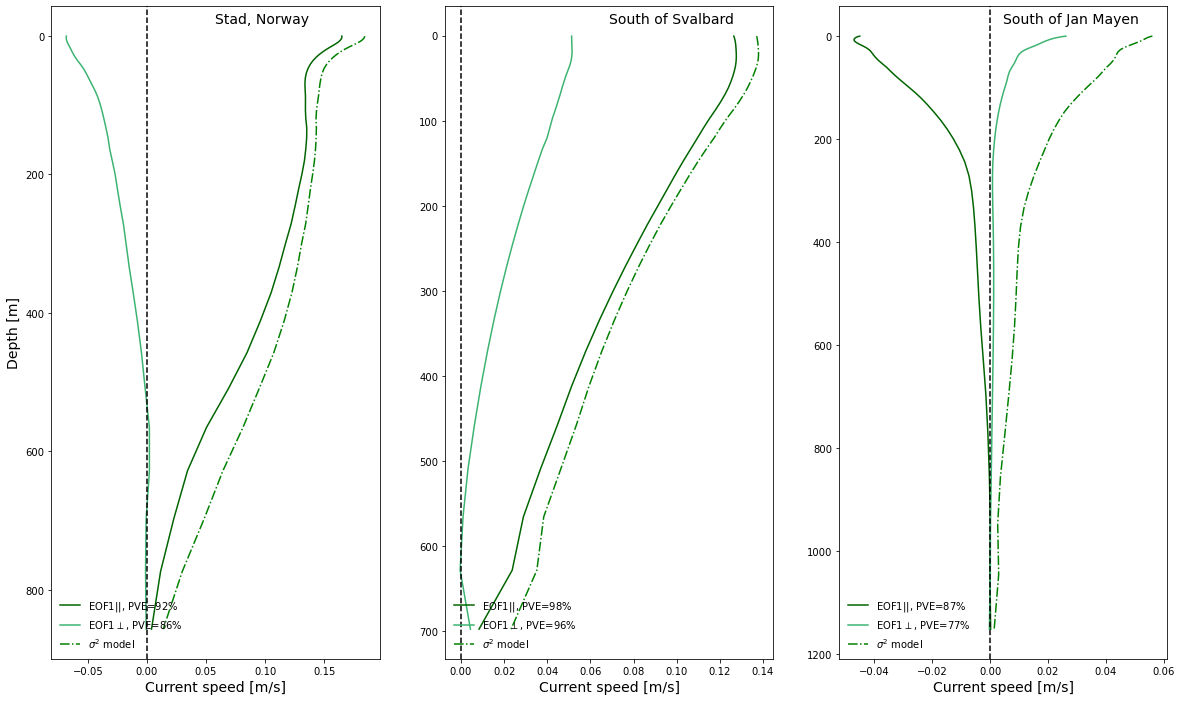

In [9]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,3,figsize = (20,12))
#plt.suptitle('EOF1 & EOF1-rotated from model data, ice free regions', 
#             horizontalalignment='center',
#            fontsize=24)
axes[0].set_ylabel('Depth [m]', fontsize=14)
mooring=['Stad, Norway', 'South of Svalbard','South of Jan Mayen']

for axs, i in zip(axes.flat, [0,1,2]):
    print(i)
    x = moor_l[i][0]
    y = moor_l[i][1]
    d = bathym.isel(x=x,y=y).values-1
    dypu = u.isel(x=x,y=y,depth=slice(0,d),time_counter=0)
    print(dypu.shape)
    
    # Model infrmation
    PCAp1 = data[pickl[i]]['EOF1p'][:d]
    PCAo1 = data[pickl[i]]['EOF1o'][:d]
    var_  = data[pickl[i]]['tot_var'][:d]
    PVE1p = data[pickl[i]]['PVE1p']
    PVE1o = data[pickl[i]]['PVE1o']
    
    axs.plot(PCAp1,dypu.depth, label= f'EOF1$||$, PVE={PVE1p}%', color='darkgreen') #linestyle='--',
    axs.plot(PCAo1,dypu.depth, label= f'EOF1$\perp$, PVE={PVE1o}%', color='mediumseagreen')    
    #axs.plot(PC1u,dypu.depth, 'darkred', label = f'EOF1-u, PVE={PVE1u}%')
    #axs.plot(PC1v,dypu.depth, 'coral', label= f'EOF1-v, PVE={PVE1v}%')
    axs.plot(var_.T,dypu.depth, linestyle='-.', label= f'$\sigma^2$ model', color='g')
    axs.axvline(0, color='k', linestyle = '--')
    axs.legend(frameon=False, fontsize=10, loc="lower left") 
    axs.invert_yaxis()
    axs.set_xlabel('Current speed [m/s]', fontsize=14)
    axs.text(0.50, 0.97, f'{mooring[i]}', color='k', fontsize=14, transform=axs.transAxes, verticalalignment='bottom')
    
plt.savefig('EOFs_icefree_mod.pdf', dpi = 300)

## ice and sloe

In [35]:
len(data['ice_slope_lofoten_basin']['EOF1p'])

32

In [46]:
len(data[pickl[4]]['tot_var'])

32

In [47]:
bathym

<xarray.DataArray 'mbathy' (y: 1150, x: 1200)>
dask.array<getitem, shape=(1150, 1200), dtype=int16, chunksize=(1150, 1200), chunktype=numpy.ndarray>
Dimensions without coordinates: y, x

3
870 600
(42,)
42
4
870 845
(48,)
48
5
475 525
(41,)
41


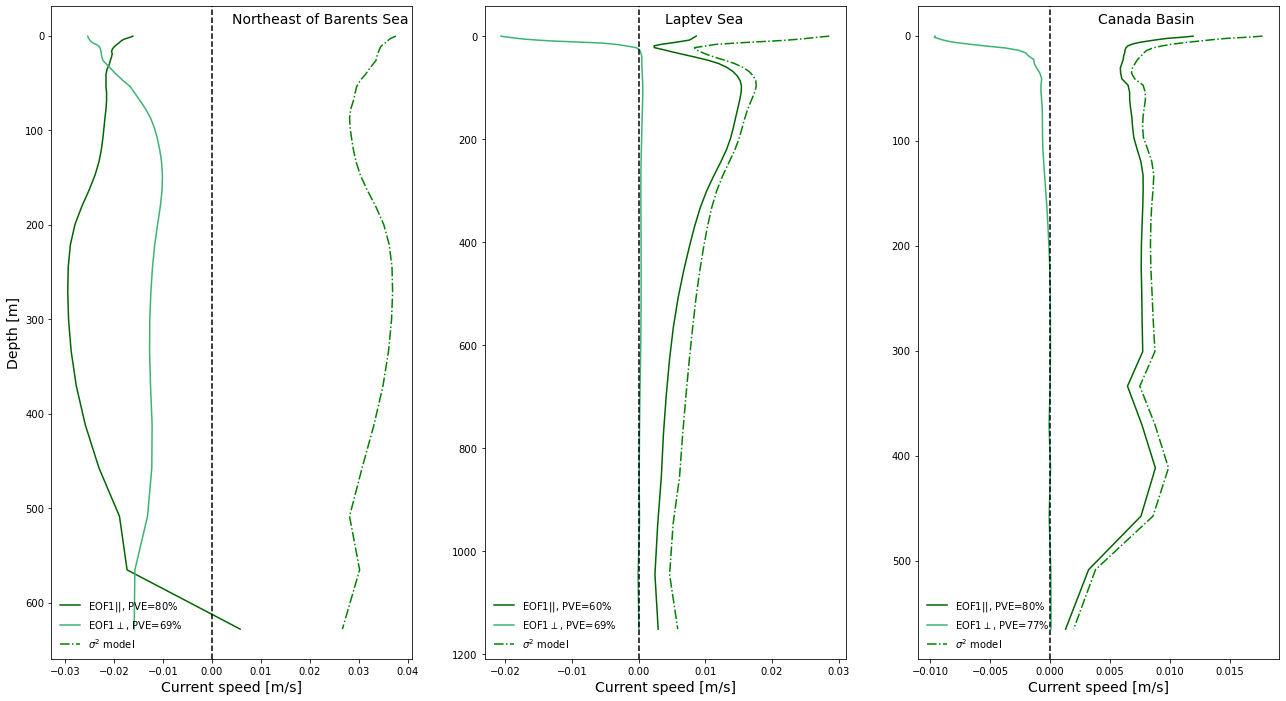

In [10]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,3,figsize = (22,12))
#plt.suptitle('EOF1 & EOF1-rotated from model data, ice rgions on the slope', 
#             horizontalalignment='center',
#            fontsize=24)
axes[0].set_ylabel('Depth [m]', fontsize=14)
mooring=['Northeast of Barents Sea', 'Laptev Sea','Canada Basin']

for axs, i in zip(axes.flat, [3,4,5]):
    print(i)
    x = moor_l[i][0]
    y = moor_l[i][1]
    print(x,y)
    d = bathym.isel(x=x,y=y).values-1
    dypu = u.isel(x=x,y=y,depth=slice(0,d),time_counter=0)
    print(dypu.shape)
    
    # Model infrmation
    PCAp1 = data[pickl[i]]['EOF1p'][:d]
    PCAo1 = data[pickl[i]]['EOF1o'][:d]
    var_  = data[pickl[i]]['tot_var'][:d]
    PVE1p = data[pickl[i]]['PVE1p']
    PVE1o = data[pickl[i]]['PVE1o']
    print(len(PCAp1))
    
    axs.plot(PCAp1,dypu.depth, label= f'EOF1$||$, PVE={PVE1p}%', color='darkgreen') #linestyle='--',
    axs.plot(PCAo1,dypu.depth, label= f'EOF1$\perp$, PVE={PVE1o}%', color='mediumseagreen')    
    #axs.plot(PC1u,dypu.depth, 'darkred', label = f'EOF1-u, PVE={PVE1u}%')
    #axs.plot(PC1v,dypu.depth, 'coral', label= f'EOF1-v, PVE={PVE1v}%')
    axs.plot(var_.T,dypu.depth, linestyle='-.', label= f'$\sigma^2$ model', color='g')
    axs.axvline(0, color='k', linestyle = '--')
    axs.legend(frameon=False, fontsize=10, loc="lower left") 
    axs.invert_yaxis()
    axs.set_xlabel('Current speed [m/s]', fontsize=14)
    axs.text(0.50, 0.97, f'{mooring[i-3]}', color='k', fontsize=14, transform=axs.transAxes, verticalalignment='bottom')
    
    
plt.savefig('EOFs_iceslope_mod.pdf', dpi = 300)

## ice and flat bottom

6
(47,)
7
(29,)


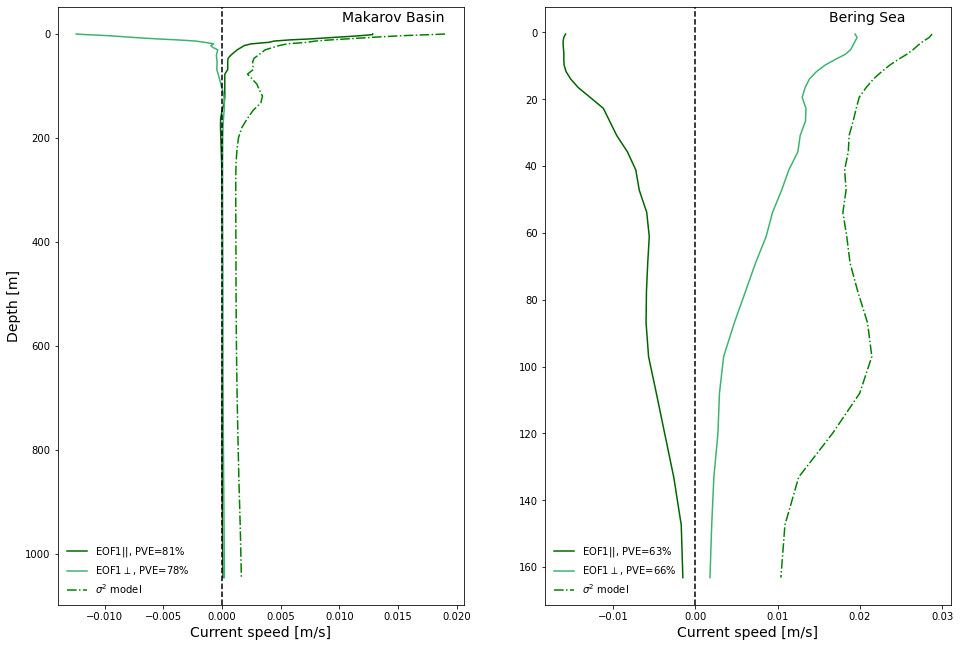

In [11]:
warnings.simplefilter("ignore")
fig, axes = plt.subplots(1,2,figsize = (16,11))

axes[0].set_ylabel('Depth [m]', fontsize=14)
mooring=['Makarov Basin','Bering Sea']

for axs, i in zip(axes.flat, [6,7]):
    print(i)
    x = moor_l[i][0]
    y = moor_l[i][1]
    d = bathym.isel(x=x,y=y).values-1
    dypu = u.isel(x=x,y=y,depth=slice(0,d),time_counter=0)
    print(dypu.shape)
    
    # Model infrmation
    PCAp1 = data[pickl[i]]['EOF1p'][:d]
    PCAo1 = data[pickl[i]]['EOF1o'][:d]
    var_  = data[pickl[i]]['tot_var'][:d]
    PVE1p = data[pickl[i]]['PVE1p']
    PVE1o = data[pickl[i]]['PVE1o']
    
    axs.plot(PCAp1,dypu.depth, label= f'EOF1$||$, PVE={PVE1p}%', color='darkgreen') #linestyle='--',
    axs.plot(PCAo1,dypu.depth, label= f'EOF1$\perp$, PVE={PVE1o}%', color='mediumseagreen')    
    #axs.plot(PC1u,dypu.depth, 'darkred', label = f'EOF1-u, PVE={PVE1u}%')
    #axs.plot(PC1v,dypu.depth, 'coral', label= f'EOF1-v, PVE={PVE1v}%')
    axs.plot(var_.T,dypu.depth, linestyle='-.', label= f'$\sigma^2$ model', color='g')
    axs.axvline(0, color='k', linestyle = '--')
    axs.legend(frameon=False, fontsize=10, loc="lower left") 
    axs.invert_yaxis()
    axs.set_xlabel('Current speed [m/s]', fontsize=14)
    axs.text(0.70, 0.97, f'{mooring[i-6]}', color='k', fontsize=14, transform=axs.transAxes, verticalalignment='bottom')
    
plt.savefig('EOFs_iceflatt_mod.pdf', dpi = 300)